In [19]:
from collections import Counter
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from pandas.plotting import scatter_matrix

import mplfinance as mpf

import numpy as np

import pandas as pd
import pandas_datareader.data as web

style.use('ggplot')

In [2]:
start = dt.datetime(2018, 4, 2)
end = dt.datetime.now()

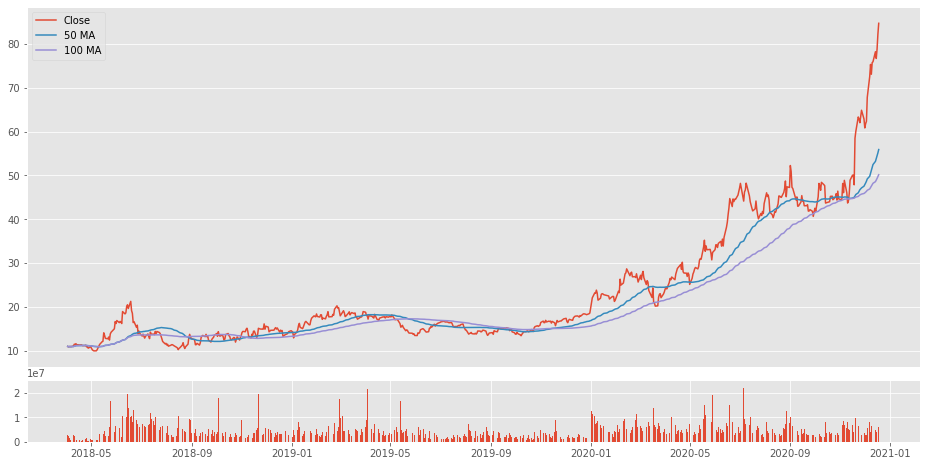

In [3]:
df = web.DataReader('BILI', 'yahoo', start, end)
df['50 MA'] = df['Adj Close'].rolling(50, min_periods=0).mean()
df['100 MA'] = df['Adj Close'].rolling(100, min_periods=0).mean()

fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
ax1.plot(df.index, df['Adj Close'], label='Close')
ax1.plot(df.index, df['50 MA'], label='50 MA')
ax1.plot(df.index, df['100 MA'], label='100 MA')
ax1.get_xaxis().set_visible(False)
ax2.bar(df.index, df['Volume'])
ax1.legend()


In [4]:
df_ohlc = df['Adj Close'].resample('7D').ohlc()
df_ohlc['volume'] = df['Volume'].resample('7D').sum()
df_ohlc

,open,high,low,close,volume
Date,,,,,
2018-04-02,11.000000,11.000000,10.910000,10.940000,8356800
2018-04-09,11.100000,11.620000,11.100000,11.400000,9223400
2018-04-16,11.330000,11.350000,11.190000,11.190000,2838200
2018-04-23,11.190000,11.290000,10.610000,10.610000,4459400
2018-04-30,10.920000,10.920000,9.990000,9.990000,4029100
...,...,...,...,...,...
2020-11-16,50.049999,60.000000,47.849998,60.000000,52004900
2020-11-23,63.320000,64.860001,62.009998,64.860001,17002600
2020-11-30,62.860001,67.790001,60.820000,67.790001,19808300


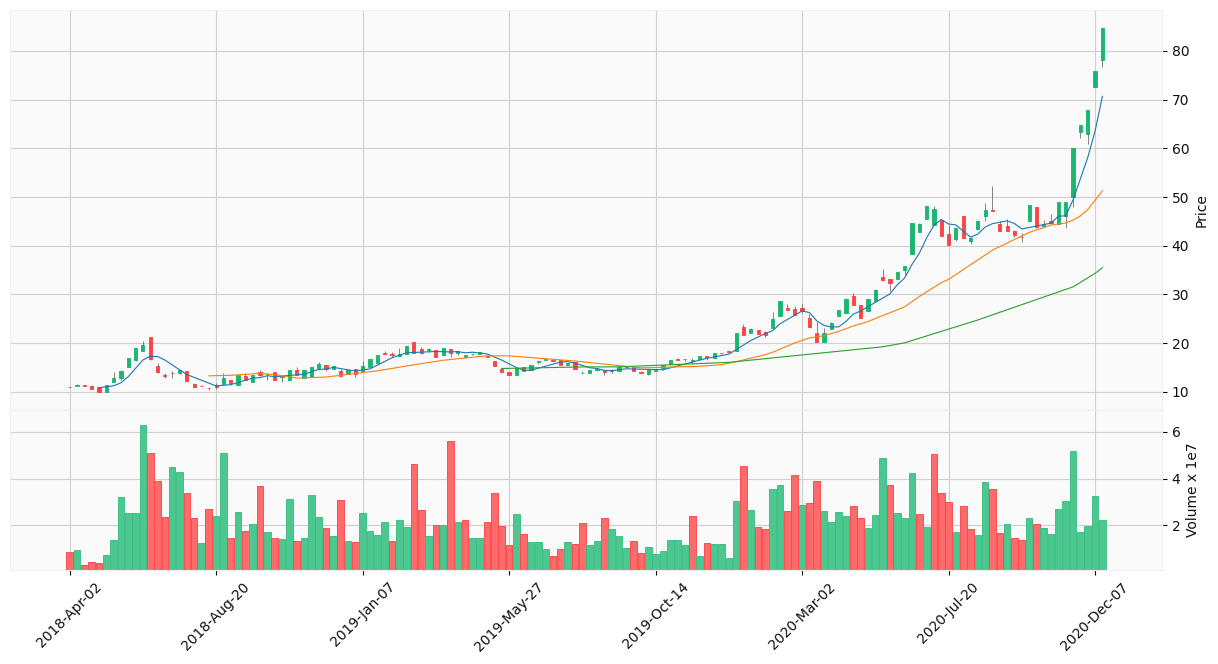

In [5]:
mpf.plot(df_ohlc, type='candle', style='yahoo', mav=(5,20,60), volume=True, figsize=(16, 8))

## Retrieve S&P 500 tickers

In [6]:
import pickle
try:
    with open('sp500.pickle', 'rb') as f:
        tickers = pickle.load(f)
except IOError:
    import bs4 as bs
    import requests
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table', {'id': 'constituents'})
    tickers = [row.findAll('td')[0].text.strip() for row in table.findAll('tr')[1:]]
    with open('sp500.pickle', 'wb') as f:
        pickle.dump(tickers, f)

## Save all S&P 500 ticker history data

In [7]:
import os
if not os.path.exists('stocks'):
    os.makedirs('stocks')
s = dt.datetime(1980, 1, 1)
e = dt.datetime.now()
dfs = {}
for ticker in tickers:
    yahoo_ticker = ticker.replace('.', '-')
    filename = 'stocks/%s.parquet.gzip' % yahoo_ticker
    if not os.path.exists(filename):
        dfs[ticker] = web.DataReader(yahoo_ticker, 'yahoo', s, e)
        print('%s!' % ticker, end='')
        dfs[ticker].to_parquet(filename, compression='gzip')
    else:
        dfs[ticker] = pd.read_parquet(filename)
        print('%s ' % ticker, end='')

MMM ABT ABBV ABMD ACN ATVI ADBE AMD AAP AES AFL A APD AKAM ALK ALB ARE ALXN ALGN ALLE LNT ALL GOOGL GOOG MO AMZN AMCR AEE AAL AEP AXP AIG AMT AWK AMP ABC AME AMGN APH ADI ANSS ANTM AON AOS APA AIV AAPL AMAT APTV ADM ANET AJG AIZ T ATO ADSK ADP AZO AVB AVY BKR BLL BAC BK BAX BDX BRK.B BBY BIO BIIB BLK BA BKNG BWA BXP BSX BMY AVGO BR BF.B CHRW COG CDNS CPB COF CAH KMX CCL CARR CTLT CAT CBOE CBRE CDW CE CNC CNP CERN CF SCHW CHTR CVX CMG CB CHD CI CINF CTAS CSCO C CFG CTXS CLX CME CMS KO CTSH CL CMCSA CMA CAG CXO COP ED STZ COO CPRT GLW CTVA COST CCI CSX CMI CVS DHI DHR DRI DVA DE DAL XRAY DVN DXCM FANG DLR DFS DISCA DISCK DISH DG DLTR D DPZ DOV DOW DTE DUK DRE DD DXC EMN ETN EBAY ECL EIX EW EA EMR ETR EOG EFX EQIX EQR ESS EL ETSY EVRG ES RE EXC EXPE EXPD EXR XOM FFIV FB FAST FRT FDX FIS FITB FE FRC FISV FLT FLIR FLS FMC F FTNT FTV FBHS FOXA FOX BEN FCX GPS GRMN IT GD GE GIS GM GPC GILD GL GPN GS GWW HAL HBI HIG HAS HCA PEAK HSIC HSY HES HPE HLT HFC HOLX HD HON HRL HST HWM HPQ HUM HBAN HII

## Save aggregated S&P 500 Adj Close Data

In [8]:
sp500_file = 'stocks/sp500.parquet.gzip'
sp500_df = pd.DataFrame()
if not os.path.exists(sp500_file):
    for ticker in tickers:
        sp500_df[ticker] = dfs[ticker]['Adj Close']
    sp500_df.to_parquet(sp500_file, compression='gzip')
    print('SP 500 processed.')
else:
    sp500_df = pd.read_parquet(sp500_file)
    print('SP 500 loaded.')
sp500_df.tail()

SP 500 loaded.


,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-14,173.080002,106.790001,104.199997,267.619995,243.750000,85.940002,486.420013,94.779999,157.315826,21.299999,...,107.540001,65.040001,22.740000,149.029999,97.139999,105.500000,383.459991,142.589996,40.709999,159.500000
2020-12-15,174.679993,107.449997,102.820000,275.359985,247.050003,86.919998,482.640015,97.120003,159.592285,22.280001,...,114.099998,66.019997,23.760000,152.110001,99.769997,107.379997,383.450012,147.809998,41.610001,161.960007
2020-12-16,175.410004,107.339996,104.639999,274.140015,247.449997,88.220001,489.899994,96.849998,161.070007,21.900000,...,115.230003,65.589996,23.030001,151.750000,99.019997,107.419998,377.410004,148.850006,41.869999,160.619995
2020-12-17,176.649994,108.779999,104.889999,281.989990,264.470001,88.459999,495.359985,96.839996,160.339996,22.090000,...,114.809998,67.010002,23.129999,151.860001,99.750000,108.790001,375.429993,151.360001,41.869999,162.699997
2020-12-18,176.419998,108.970001,104.449997,293.390015,266.250000,90.370003,502.950012,95.919998,159.990005,22.540001,...,115.930000,66.099998,22.860001,149.190002,100.050003,109.779999,373.000000,151.850006,41.080002,163.630005


In [130]:
sp500_df.shape

(10332, 505)

## Correlation

In [131]:
sp500_corr = sp500_df.corr()

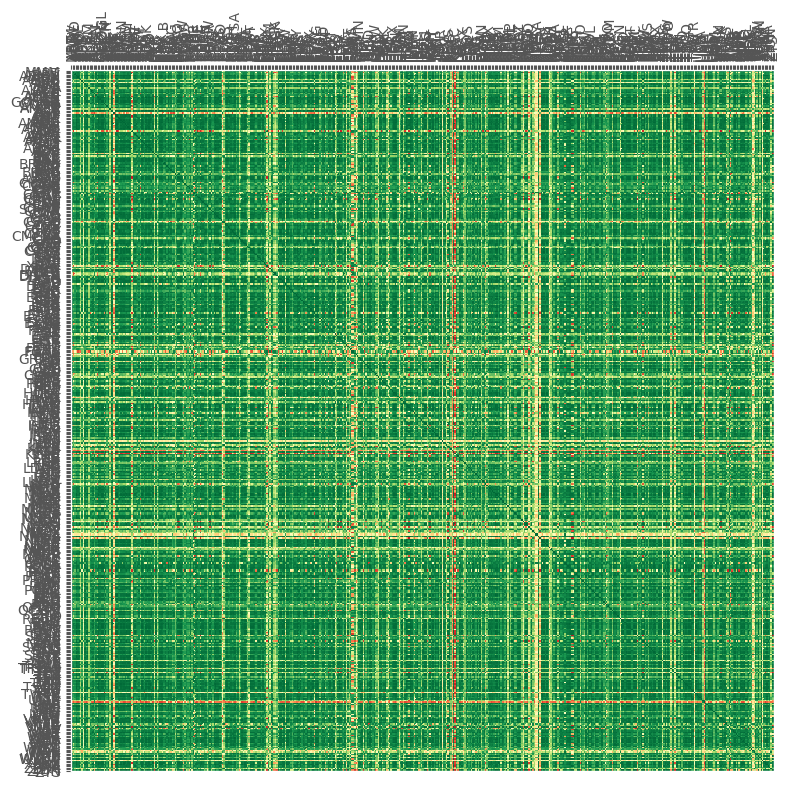

In [140]:
data = sp500_corr.values
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
ax.invert_yaxis()
ax.xaxis.tick_top()

column_labels = sp500_corr.columns
row_labels = sp500_corr.index

ax.set_xticklabels(column_labels)
ax.set_yticklabels(row_labels)
plt.xticks(rotation=90)
heatmap.set_clim(-1, 1)
plt.tight_layout()

## Prediction based on S&P 500 data

In [17]:
hm_days = 7
sp500_ext_file = 'stocks/sp500_{}.parquet.gzip'.format(hm_days)
sp500_ext_df = pd.DataFrame()
if not os.path.exists(sp500_ext_file):
    df = sp500_df.copy()
    for ticker in tickers:
        for i in range(1, hm_days+1):
            df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    df.to_parquet(sp500_ext_file, compression='gzip')
    sp500_ext_df = df
    print('SP 500 ext processed.')
else:
    sp500_ext_df = pd.read_parquet(sp500_ext_file)
    print('SP 500 ext loaded.')
sp500_ext_df

SP 500 ext loaded.


,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,ZION_5d,ZION_6d,ZION_7d,ZTS_1d,ZTS_2d,ZTS_3d,ZTS_4d,ZTS_5d,ZTS_6d,ZTS_7d
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,1.701496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1980-01-03,1.632749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1980-01-04,1.632749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1980-01-07,1.641342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1980-01-08,1.701496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,173.080002,106.790001,104.199997,267.619995,243.750000,85.940002,486.420013,94.779999,157.315826,21.299999,...,0.0,0.0,0.0,0.015423,0.007022,0.020063,0.025893,0.0,0.0,0.0
2020-12-15,174.679993,107.449997,102.820000,275.359985,247.050003,86.919998,482.640015,97.120003,159.592285,22.280001,...,0.0,0.0,0.0,-0.008274,0.004569,0.010311,0.000000,0.0,0.0,0.0
2020-12-16,175.410004,107.339996,104.639999,274.140015,247.449997,88.220001,489.899994,96.849998,161.070007,21.900000,...,0.0,0.0,0.0,0.012950,0.018740,0.000000,0.000000,0.0,0.0,0.0


## Buy, sell and Hold

In [21]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0

sp500_target_file = 'stocks/sp500_{}_target.parquet.gzip'.format(hm_days)
sp500_target_df = pd.DataFrame()
if not os.path.exists(sp500_target_file):
    df = sp500_ext_df.copy()
    for ticker in tickers:
        df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                                  df['{}_1d'.format(ticker)],
                                                  df['{}_2d'.format(ticker)],
                                                  df['{}_3d'.format(ticker)],
                                                  df['{}_4d'.format(ticker)],
                                                  df['{}_5d'.format(ticker)],
                                                  df['{}_6d'.format(ticker)],
                                                  df['{}_7d'.format(ticker)]
                                                 ))
        vals = df['{}_target'.format(ticker)].values.tolist()
        str_vals = [str(i) for i in vals]
        print('{} spread: {}'.format(ticker, Counter(str_vals)))
        
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df.to_parquet(sp500_target_file, compression='gzip')
    sp500_target_df = df
    print('SP 500 target processed.')
else:
    sp500_target_df = pd.read_parquet(sp500_target_file)
    print('SP 500 target loaded.')
sp500_target_df

SP 500 target loaded.


,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WYNN_target,XEL_target,XRX_target,XLNX_target,XYL_target,YUM_target,ZBRA_target,ZBH_target,ZION_target,ZTS_target
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,1.701496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,-1,0,0,0,0,0,0,0
1980-01-03,1.632749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,1,0,0,0,0,0,0,0
1980-01-04,1.632749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,1,0,0,0,0,0,0,0
1980-01-07,1.641342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,-1,1,0,0,0,0,0,0,0
1980-01-08,1.701496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,-1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-14,173.080002,106.790001,104.199997,267.619995,243.750000,85.940002,486.420013,94.779999,157.315826,21.299999,...,1,1,1,1,1,1,-1,1,1,1
2020-12-15,174.679993,107.449997,102.820000,275.359985,247.050003,86.919998,482.640015,97.120003,159.592285,22.280001,...,0,0,-1,0,0,1,-1,1,0,0
2020-12-16,175.410004,107.339996,104.639999,274.140015,247.449997,88.220001,489.899994,96.849998,161.070007,21.900000,...,0,1,0,0,0,1,0,1,0,0


## Machine learning

In [39]:
from sklearn import svm, model_selection, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

df_vals = sp500_target_df[[ticker for ticker in tickers]].pct_change()
df_vals = df_vals.replace([np.inf, -np.inf], 0)
df_vals.fillna(0, inplace=True)

def do_ml(ticker):
    X = df_vals.values
    y = sp500_target_df['{}_target'.format(ticker)].values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

    model_name = '{}_model.pickle'.format(ticker)
    try:
        with open(model_name, 'rb') as f:
            clf = pickle.load(f)
            print('{} CLF loaded.'.format(ticker))
    except IOError:
        clf = VotingClassifier([('lsvm', svm.LinearSVC()),
                                ('knn', neighbors.KNeighborsClassifier()),
                                ('rfor', RandomForestClassifier())
                               ])
        clf.fit(X_train, y_train)
        with open(model_name, 'wb') as f:
            pickle.dump(clf, f)
        print('{} CLF trained.'.format(ticker))

    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    print('{} accuracy: {}, predicted spread: {}'.format(ticker, confidence, Counter(predictions)))
    return confidence

do_ml('GOOGL')

GOOGL CLF loaded.
GOOGL accuracy: 0.8768873403019745, predicted spread: Counter({0: 1880, -1: 360, 1: 343})


0.8768873403019745

In [40]:
np.random.random(100)

array([0.1629338 , 0.1443143 , 0.74187034, 0.04108569, 0.29114197,
       0.24129449, 0.68206534, 0.86734413, 0.31241113, 0.62276382,
       0.25180005, 0.54287029, 0.19592401, 0.57580112, 0.63630863,
       0.30408892, 0.54737876, 0.38929453, 0.68223063, 0.92925828,
       0.10423221, 0.41632396, 0.56973905, 0.33942836, 0.45718048,
       0.59616876, 0.88612479, 0.02901646, 0.2386075 , 0.9081237 ,
       0.81928484, 0.61028914, 0.53649476, 0.92771258, 0.56447863,
       0.60769481, 0.31228531, 0.28644315, 0.64879858, 0.62463987,
       0.26155927, 0.90086947, 0.25926821, 0.42082416, 0.44699444,
       0.9518411 , 0.87340834, 0.37823979, 0.25990488, 0.15335562,
       0.42859274, 0.45700103, 0.13289683, 0.62079207, 0.51249638,
       0.88397083, 0.46463037, 0.44752323, 0.4210216 , 0.62120994,
       0.25596291, 0.87006635, 0.55728549, 0.28501296, 0.02972227,
       0.50652447, 0.82419554, 0.78666626, 0.99514129, 0.72807674,
       0.92341491, 0.33921532, 0.20038431, 0.11286207, 0.80544